# XAI notebook
Notebook defines way to test different CNN explainability techniques. This metric used masking and GAN to change the background of the given object in (classification) task.

In [1]:
import torch
import torchvision
import numpy as np
import cv2
from PIL import Image
from utils import map_from_list
from torchvision.datasets import VOCDetection, Caltech101, VOCSegmentation, ImageFolder
import torchvision.transforms as transforms
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

## Load datasets and pretrained networks

In [3]:

# Choose model
model_name = 'ResNet'

In [4]:
if model_name == 'ResNet':
    # Import only if model used
    from torchvision.models import resnet34, ResNet34_Weights
    
    # Loads best possible pre-trained weights for ImageNet dataset (further traning needed for other datasets)
    weights = ResNet34_Weights.DEFAULT
    # Init model with weights
    model = resnet34(weights=weights)

In [5]:
if model_name == 'DenseNet':
    # Import only if model used
    from torchvision.models import densenet121, DenseNet121_Weights

    # Loads best possible pre-trained weights for ImageNet dataset (further traning needed for other datasets)
    weights = DenseNet121_Weights.DEFAULT
    # Init model with weights
    model = densenet121(weights=weights)

In [6]:
root = 'C:/Users/pette/Documents/jupterNotebooks/machinelearning/datasets' # Own data root directory here
choose_dataset = 'VOC' # VOC, Caltech, ImageNet

In [35]:
# Transforms for resnet and densenet. Output transform only needed for segmantation:
def grey_scale_to_rgb(x):
    if x.size(dim=0) == 3:
        return x
    else:
        return x.repeat(3, 1, 1)
    
def VOC_to_label(x):
    all_classes = ['horse', 'person', 'bottle', 'dog', 'tvmonitor', 'car', 'aeroplane', 'bicycle',
                   'boat', 'chair', 'diningtable', 'pottedplant', 'train', 'cat', 'sofa', 'bird',
                   'sheep', 'motorbike', 'bus', 'cow']
    final_labels = torch.zeros(len(all_classes))
    for one_object in x['annotation']['object']:
        final_labels[all_classes.index(one_object['name'])] = 1
    return final_labels

transform_input = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Lambda(grey_scale_to_rgb),
    transforms.Normalize(
         mean=[0.485, 0.456, 0.406],
         std=[0.229, 0.224, 0.225]
 )
])
transform_output = transforms.Compose([
    transforms.Lambda(VOC_to_label)
])

In [36]:
if choose_dataset == 'VOC':
    num_of_classes = 20
    dataset = VOCDetection(root, year='2012', image_set='train', download=True, transform=transform_input, target_transform=transform_output)
    dataset_original = VOCDetection(root, year='2012', image_set='train', download=True, transform=None, target_transform=None)
    #dataset_segmentation = VOCSegmentation(root, year='2012', image_set='train', download=True, transform=None, target_transform=transform_output)
elif choose_dataset == 'Caltech':
    num_of_classes = 101
    dataset = Caltech101(root, download=True, transform=transform_input, target_transform=None)
    dataset_original = Caltech101(root, download=True, transform=None, target_transform=None)
elif choose_dataset == 'ImageNet':
    num_of_classes = 1000
    root += '/imagenet_images'
    dataset = ImageFolder(root, transform=transform_input, target_transform=None)
    dataset_original = ImageFolder(root, transform=None, target_transform=None)

Using downloaded and verified file: C:/Users/pette/Documents/jupterNotebooks/machinelearning/datasets\VOCtrainval_11-May-2012.tar
Extracting C:/Users/pette/Documents/jupterNotebooks/machinelearning/datasets\VOCtrainval_11-May-2012.tar to C:/Users/pette/Documents/jupterNotebooks/machinelearning/datasets
Using downloaded and verified file: C:/Users/pette/Documents/jupterNotebooks/machinelearning/datasets\VOCtrainval_11-May-2012.tar
Extracting C:/Users/pette/Documents/jupterNotebooks/machinelearning/datasets\VOCtrainval_11-May-2012.tar to C:/Users/pette/Documents/jupterNotebooks/machinelearning/datasets


In [37]:
print(dataset[10])

(tensor([[[-1.3815, -1.4843, -1.5528,  ..., -1.8953, -1.9124, -1.8953],
         [-1.7069, -1.8097, -1.8439,  ..., -1.7240, -1.6898, -1.9295],
         [-1.8439, -1.8268, -1.8610,  ..., -1.6727, -1.0562, -1.2274],
         ...,
         [-0.3198, -0.2684, -0.1486,  ..., -1.8782, -1.9124, -1.9124],
         [-0.2684, -0.2856, -0.1314,  ..., -1.8439, -1.8953, -1.9124],
         [-0.2684, -0.2856, -0.1143,  ..., -1.8439, -1.8610, -1.8610]],

        [[-1.2829, -1.3354, -1.4580,  ..., -1.6155, -1.6856, -1.6506],
         [-1.5455, -1.5805, -1.6331,  ..., -1.5105, -1.4930, -1.6856],
         [-1.6331, -1.6506, -1.7381,  ..., -1.5105, -0.9153, -1.0903],
         ...,
         [-0.1975, -0.0749,  0.0651,  ..., -1.8256, -1.8606, -1.8431],
         [-0.1275, -0.0749,  0.0476,  ..., -1.7906, -1.8606, -1.8431],
         [-0.1099, -0.0574,  0.0651,  ..., -1.7731, -1.8256, -1.8081]],

        [[-1.2990, -1.3339, -1.3513,  ..., -1.2467, -1.3513, -1.3687],
         [-1.5081, -1.5779, -1.5430,  ..., -

In [38]:
# Create dataloader
batch_size = 4

data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

## Train the model
Model can be further trained with loaded datasets. All classification models pretrained weights are trained on Imagenet dataset.

In [39]:
train = True
load_weights = False
# Create optimizer and loss function
crit = torch.nn.CrossEntropyLoss()

momentum = 0
lr = 0.001

if choose_dataset == 'VOC':
    crit = torch.nn.BCEWithLogitsLoss()
else:
    crit = torch.nn.CrossEntropyLoss()
    
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = momentum)

# Define number of epochs used for further training
epochs = 3

In [40]:
if train:
    model.fc = torch.nn.Linear(512, num_of_classes)
    for epoch in range(epochs):
        running_loss = 0
        for i, data in enumerate(data_loader, 0):
                inputs, labels = data[0], data[1]

                optimizer.zero_grad()
                outputs = model(inputs)

                loss = crit(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                print(f"{i}/{len(data_loader)}")
        torch.save(model.state_dict(), f'weights/latest{choose_dataset}.pth')
        print(f"Loss in epoch {epoch}: {running_loss/(len(data_loader)*batch_size)}")
else:
    if load_weights:
        model.load_state_dict(torch.load(f'weights/latest{choose_dataset}.pth'))
    else:
        pass # Use pretrained weights for XAI method evaluation

0/1430
1/1430
2/1430
3/1430
4/1430
5/1430
6/1430
7/1430
8/1430
9/1430
10/1430
11/1430
12/1430
13/1430
14/1430
15/1430
16/1430
17/1430
18/1430
19/1430
20/1430
21/1430
22/1430
23/1430
24/1430
25/1430
26/1430
27/1430
28/1430
29/1430


KeyboardInterrupt: 

# GradCAM example

[3]


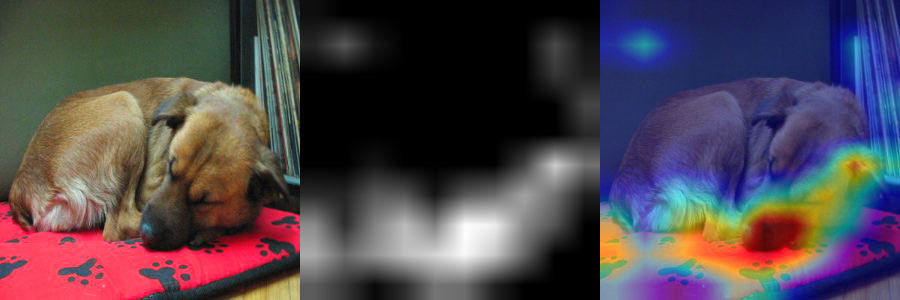

In [49]:
i = 1000
# Get transformed tensor with index
(input_tensor, labels) = dataset[i]


# Get original image with index and reshape(for plotting)
(img, label) = dataset_original[i]
img = cv2.resize(np.array(img), (300, 300))
img = np.float32(img) / 255 # Assume 8 bit pixels

input_tensor = input_tensor.unsqueeze(0)

if choose_dataset == 'VOC':
    labels = (labels==1).nonzero().squeeze().tolist()

if isinstance(labels, int):
    labels = [labels]

for label in labels:
    print(labels)
    if choose_dataset == 'ImageNet':
        label, name = map_from_list(label, dataset.find_classes(root)[0])
    # Set target as our ground truth label
    targets = [ClassifierOutputTarget(label)]
    # Define target layer
    target_layers = [model.layer4]

    # Run model with given cam
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

    # Make images the same format and plot original, greyscale and heatmap:
    cam = np.uint8(255*grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

## Threshold and create a new image

Threshold gradcam probabilities and multiply with the input tensor to get a new image to feed to the network

In [50]:
print(grayscale_cams)
threshold = 0.3
mask = (grayscale_cams > threshold).astype(int)

masked_tensor = torch.mul(input_tensor, torch.tensor(mask))
masked_image = np.uint8(255*img)*np.reshape(mask, (300,300,1))

[[[0.05689488 0.05689488 0.05689488 ... 0.         0.         0.        ]
  [0.05689488 0.05689488 0.05689488 ... 0.         0.         0.        ]
  [0.05689488 0.05689488 0.05689488 ... 0.         0.         0.        ]
  ...
  [0.36193192 0.36193192 0.36193192 ... 0.         0.         0.        ]
  [0.36193192 0.36193192 0.36193192 ... 0.         0.         0.        ]
  [0.36193192 0.36193192 0.36193192 ... 0.         0.         0.        ]]]


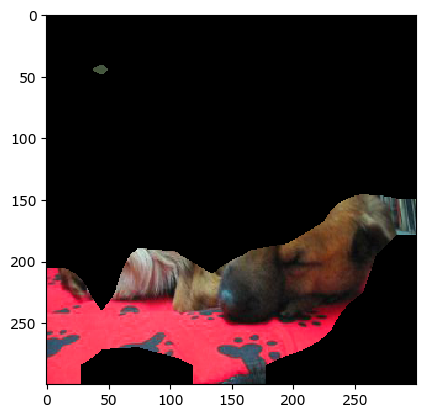

In [51]:
plt.imshow(masked_image, interpolation='nearest')
plt.show()